# Script to check mechanism's ignition delay times against experimental values

In [1]:
import os
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures
import subprocess

import matplotlib.pyplot as plt
%matplotlib inline

## Specify the mechanism to simulate and plot

In [2]:
# Load the model

AUTOSCIENCE_REPO = os.environ['AUTOSCIENCE_REPO']

# change this path to whichever mechanism you want to check
yaml_path = os.path.join(AUTOSCIENCE_REPO, 'RMG_example_fuel_YYYYMMDD/chem_annotated.yaml')

# If you only have the model as a .inp (chemkin) file, use Cantera's ck2yaml command to convert it to .yaml
chemkin_path = os.path.join(AUTOSCIENCE_REPO, 'RMG_example_fuel_YYYYMMDD/chem_annotated.inp')
transport_path = os.path.join(os.path.dirname(chemkin_path), 'tran.dat')
if not os.path.exists(yaml_path) and os.path.exists(chemkin_path):
    subprocess.run(['ck2yaml', f'--input={chemkin_path}', f'--transport={transport_path}'])

gas = ct.Solution(yaml_path)

## Load the experimental conditions

In [4]:
# This uses the Healy 2010 data
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016

ignition_delay_data = os.path.join(AUTOSCIENCE_REPO, 'experiment/butane_ignition_delay.csv')
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm

# list of starting conditions
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

    
# # Aramco naming:
# x_diluent = 0.7649
# conc_dict = {
#     'O2': 0.2038,
#     'C4H10': 0.03135
# }

# for i in range(0, len(table7)):
#     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
#     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
#     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
#     conc_dict['N2'] = x_N2
#     conc_dict['AR'] = x_Ar
#     conc_dict['CO2'] = x_CO2
#     concentrations.append(conc_dict)


## Run Simulations

In [5]:
# Take Reactor Conditions from Table 7 of supplementary info in
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
def get_delay(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X

    env = ct.Reservoir(ct.Solution('air.yaml'))
    # env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    # # allegedly faster solving
    # reactor_net.derivative_settings = {"skip-third-bodies": True, "skip-falloff": True}
    # reactor_net.preconditioner = ct.AdaptivePreconditioner()

    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)

    slopes = np.gradient(P, times)
    i = np.argmax(slopes)
    return times[i]

In [6]:
def run_simulation(condition_index):
    gas = ct.Solution(yaml_path)
    X = concentrations[condition_index]
    delay = get_delay(gas, T7[condition_index], P7[condition_index], X)
    print(f'Completed {condition_index}:\t {delay}')
    return delay

In [7]:
# Run all simulations in parallel, takes on the order of minutes
delays = np.zeros(len(table7))
condition_indices = np.arange(0, len(table7))
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    for condition_index, delay_time in zip(condition_indices, executor.map(run_simulation, condition_indices)):
        delays[condition_index] = delay_time

Completed 13:	 0.015433100452373078
Completed 15:	 0.012824434490874134
Completed 14:	 0.015266450802568759Completed 10:	 0.012204272451122128

Completed 12:	 0.01580340036195149
Completed 11:	 0.013625584496579248
Completed 9:	 0.008689964130477892
Completed 8:	 0.007638128987802816
Completed 7:	 0.004658295964991121
Completed 4:	 0.004556761563453003
Completed 5:	 0.004531732630200333
Completed 6:	 0.0046274633064936075
Completed 2:	 0.005968990613627407
Completed 3:	 0.00588151885120555
Completed 0:	 0.010912387944433449
Completed 1:	 0.010660126947149256


## Plot results

In [8]:
# Saved ignition delays for comparison:
base_rmg7_24 = np.array([0.04908328, 0.04854439, 0.04814446, 0.04868176, 0.075588  ,
       0.07737167, 0.14791668, 0.14857535, 0.1085917 , 0.0952434 ,
       0.06520823, 0.05563237, 0.03535775, 0.02462961, 0.02334903,
       0.01398333])  # 24 hour RMG run - 110 species

aramco7 = np.array([0.03945921, 0.03874611, 0.02817182, 0.02812066, 0.03236667,
       0.03278732, 0.06009581, 0.06085926, 0.06020536, 0.05459522,
       0.03965133, 0.03435827, 0.02245863, 0.01580939, 0.01499945,
       0.00896072])
experiment7 = np.array([0.0865 , 0.0739 , 0.0313 , 0.033  , 0.0309 , 0.03   , 0.056  ,
       0.0566 , 0.0679 , 0.0664 , 0.0652 , 0.0671 , 0.047  , 0.0279 ,
       0.02805, 0.012  ])


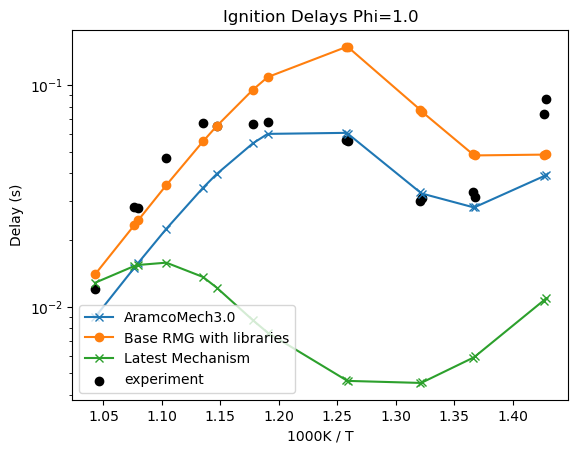

In [9]:
# plot the ignition delay

plt.plot(1000.0 / T7, aramco7, marker='x', label='AramcoMech3.0')
plt.plot(1000.0 / T7, base_rmg7_24, marker='o', label='Base RMG with libraries')
plt.plot(1000.0 / T7, delays, marker='x', label='Latest Mechanism')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='experiment')
ax = plt.gca()
ax.set_yscale('log')
plt.legend()
# plt.legend(['Mechanism 174', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['RMG 24', 'RMG 1 week', 'Aramco', 'new calculation', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)